In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
import numpy as np
import re

df = pd.read_csv("two-years-recid.csv")

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6114 entries, 0 to 6113
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     6114 non-null   int64 
 1   name                   6114 non-null   object
 2   sex                    6114 non-null   object
 3   dob                    6114 non-null   object
 4   age                    6114 non-null   int64 
 5   race                   6114 non-null   object
 6   c_jail_in              5854 non-null   object
 7   c_jail_out             5854 non-null   object
 8   c_case_number          6096 non-null   object
 9   c_offense_date         5155 non-null   object
 10  c_arrest_date          941 non-null    object
 11  c_charge_degree        6114 non-null   object
 12  c_charge_desc          6090 non-null   object
 13  juv_fel_count          6114 non-null   int64 
 14  juv_misd_count         6114 non-null   int64 
 15  juv_other_count      

In [3]:
columns_to_drop = ['c_jail_out', 'compas_screening_date',
 'type_of_assessment',
 'decile_score',
 'score_text',
 'v_type_of_assessment',
 'v_decile_score',
 'v_score_text',
 'r_case_number',
 'r_offense_date',
 'r_charge_degree',
 'r_charge_desc',
 'is_violent_recid',
 'vr_case_number',
 'vr_offense_date',
 'vr_charge_degree',
 'vr_charge_desc',
 'two_year_recid']
df = df.drop(columns=columns_to_drop)

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
import numpy as np
import re

# Funções de limpeza e transformação
def clean_c_charge_degree(degree):
    return re.sub(r'[^a-zA-Z]', '', degree)

def extract_year(date):
    return pd.to_datetime(date).year

def extract_month(date):
    return pd.to_datetime(date).month

def process_dates(df):
    df['dob_year'] = df['dob'].apply(extract_year)
    df['c_jail_year'] = df['c_jail_in'].apply(extract_year)
    df['c_jail_month'] = df['c_jail_in'].apply(extract_month)
    return df.drop(columns=['dob', 'c_jail_in'])

def agrupar_tipo_crime(descricao):
    if pd.isna(descricao):
        return 'other'
    descricao = descricao.lower()
    if 'battery' in descricao or 'assault' in descricao or 'violence' in descricao or 'murder' in descricao or 'batt' in descricao:
        return 'violence'
    elif 'theft' in descricao or 'burglary' in descricao or 'robbery' in descricao:
        return 'robbery'
    elif 'drug' in descricao or 'possession' in descricao or 'trafficking' in descricao or 'poss' in descricao or 'cocaine' in descricao or 'heroin' in descricao or 'deliver' in descricao or 'traffick' in descricao:
        return 'drugs'
    elif 'driving' in descricao or 'traffic' in descricao or 'license' in descricao or 'driv' in descricao or 'vehicle' in descricao or 'conduct' in descricao:
        return 'traffic'
    else:
        return 'other'

def group_races(df):
    race_map = df['race'].value_counts()
    common_races = race_map[race_map >= 50].index.tolist()
    df['race_grouped'] = df['race'].apply(lambda x: x if x in common_races else 'Other')
    return df.drop(columns=['race'])

def clean_data(df):
    # Drop columns
    df = df.drop(columns=['id', 'name', 'c_case_number', 'c_offense_date', 'c_arrest_date'])
    
    # Apply custom transformations
    df['c_charge_degree'] = df['c_charge_degree'].apply(clean_c_charge_degree)
    df['c_charge_desc'] = df['c_charge_desc'].apply(agrupar_tipo_crime)
    # Group races
    df = group_races(df)
    
    # Convert to categorical
    df['c_charge_desc'] = pd.Categorical(df['c_charge_desc'], categories=['violence', 'robbery', 'drugs', 'traffic', 'other'])
    df['sex'] = df['sex'].astype('category')
    df['race_grouped'] = df['race_grouped'].astype('category')
    df['c_charge_degree'] = df['c_charge_degree'].astype('category')
    
    # Process dates
    df = process_dates(df)
    
    return df

# Função para calcular métricas específicas para a classe de recidivismo (1)
def get_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, pos_label=1)
    recall = recall_score(y_true, y_pred, pos_label=1)
    f1 = f1_score(y_true, y_pred, pos_label=1)
    accuracy = accuracy_score(y_true, y_pred)
    return precision, recall, f1, accuracy

# Dados de entrada
numerical_cols = ['juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'dob_year', 'c_jail_year', 'c_jail_month']
categorical_cols = ['sex', 'race_grouped', 'c_charge_degree', 'c_charge_desc']

# Criando preprocessador
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, interaction_only=False, include_bias=False))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Definindo os classificadores individuais
xgb_clf = XGBClassifier(
    colsample_bytree=0.9086987696743714,
    learning_rate=0.191928717897877,
    max_depth=5,
    n_estimators=211,
    scale_pos_weight=5,
    subsample=0.9461200982120006,
    use_label_encoder=False,
    eval_metric='logloss'
)

rf_clf = RandomForestClassifier(n_estimators=200, random_state=42)

lr_clf = LogisticRegression(max_iter=200, random_state=42)

# Definindo o ensemble (voting classifier)
ensemble_clf = VotingClassifier(
    estimators=[('xgb', xgb_clf), ('rf', rf_clf), ('lr', lr_clf)],
    voting='soft'
)

# Definindo o pipeline
pipeline = Pipeline(steps=[
    ('data_cleaner', FunctionTransformer(clean_data, validate=False)),
    ('preprocessor', preprocessor)
])

# Dividindo os dados em treino e teste
X = df.drop(columns=['is_recid'])
y = df['is_recid']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Ajustando o pipeline nos dados de treino
pipeline.fit(X_train, y_train)

# Transformando os dados de treino e teste
X_train_transformed = pipeline.transform(X_train)
X_test_transformed = pipeline.transform(X_test)

# Ajustando o classificador com os dados transformados de treino
ensemble_clf.fit(X_train_transformed, y_train)

# Calculando as métricas com o threshold de 0.6
y_pred_proba = ensemble_clf.predict_proba(X_test_transformed)[:, 1]
threshold = 0.6
y_pred = (y_pred_proba >= threshold).astype(int)

overall_precision, overall_recall, overall_f1, overall_accuracy = get_metrics(y_test, y_pred)
print(f"Threshold: {threshold}")
print(f"Overall Precision: {overall_precision:.2f}, Recall: {overall_recall:.2f}, F1-Score: {overall_f1:.2f}, Accuracy: {overall_accuracy:.2f}")

# Adicionar novamente a coluna 'race_grouped' nos dados de teste
X_test_cleaned = clean_data(X_test)

# Calculando métricas por raça agrupada
y_pred_series = pd.Series(y_pred, index=X_test.index)
print("\nMetrics by grouped race:")
for race in X_test_cleaned['race_grouped'].unique():
    race_indices = X_test_cleaned.index[X_test_cleaned['race_grouped'] == race]
    y_test_race = y_test.loc[race_indices]
    y_pred_race = y_pred_series.loc[race_indices]

    race_precision, race_recall, race_f1, race_accuracy = get_metrics(y_test_race, y_pred_race)
    print(f"Metrics for race: {race}")
    print(f"Precision: {race_precision:.2f}, Recall: {race_recall:.2f}, F1-Score: {race_f1:.2f}, Accuracy: {race_accuracy:.2f}")


Threshold: 0.6
Overall Precision: 0.76, Recall: 0.64, F1-Score: 0.70, Accuracy: 0.73

Metrics by grouped race:
Metrics for race: African-American
Precision: 0.76, Recall: 0.70, F1-Score: 0.73, Accuracy: 0.71
Metrics for race: Caucasian
Precision: 0.77, Recall: 0.55, F1-Score: 0.64, Accuracy: 0.75
Metrics for race: Hispanic
Precision: 0.71, Recall: 0.62, F1-Score: 0.66, Accuracy: 0.76
Metrics for race: Other
Precision: 0.73, Recall: 0.44, F1-Score: 0.55, Accuracy: 0.70


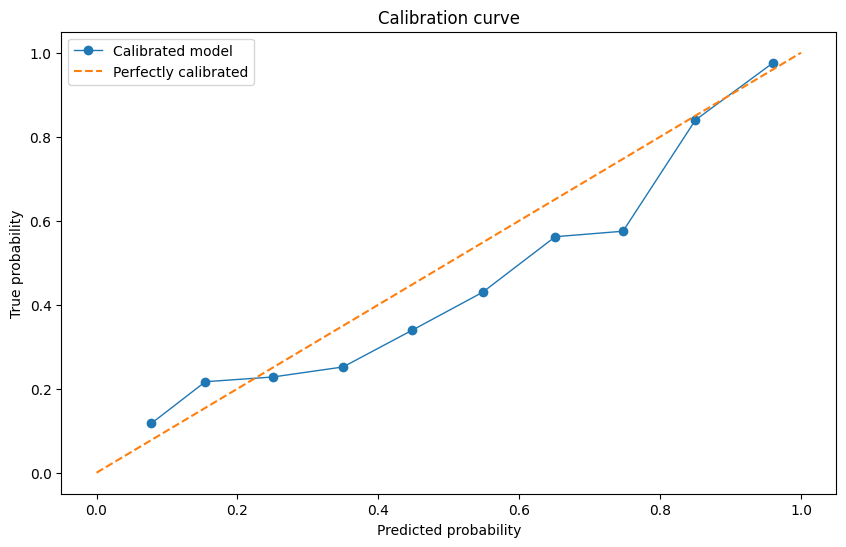

Overall Errors:
{'precision': 0.7606490872210954, 'recall': 0.6399317406143344, 'f1': 0.6950880444856349, 'accuracy': 0.7309893704006541, 'brier_score': 0.1861388339063053}

Errors by Race:
Race: African-American
{'precision': 0.7641509433962265, 'recall': 0.7023121387283237, 'f1': 0.7319277108433735, 'accuracy': 0.7142857142857143, 'brier_score': 0.1863633203602728}
Race: Caucasian
{'precision': 0.773109243697479, 'recall': 0.5476190476190477, 'f1': 0.6411149825783972, 'accuracy': 0.7524038461538461, 'brier_score': 0.1820310025942365}
Race: Hispanic
{'precision': 0.7073170731707317, 'recall': 0.6170212765957447, 'f1': 0.6590909090909091, 'accuracy': 0.7580645161290323, 'brier_score': 0.18802215999569702}
Race: Other
{'precision': 0.7333333333333333, 'recall': 0.44, 'f1': 0.55, 'accuracy': 0.7, 'brier_score': 0.20839667273820991}


/home/ana/.virtualenvs/capstone/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ana/.virtualenvs/capstone/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ana/.virtualenvs/capstone/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/home/ana/.virtualenvs/capstone/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinst

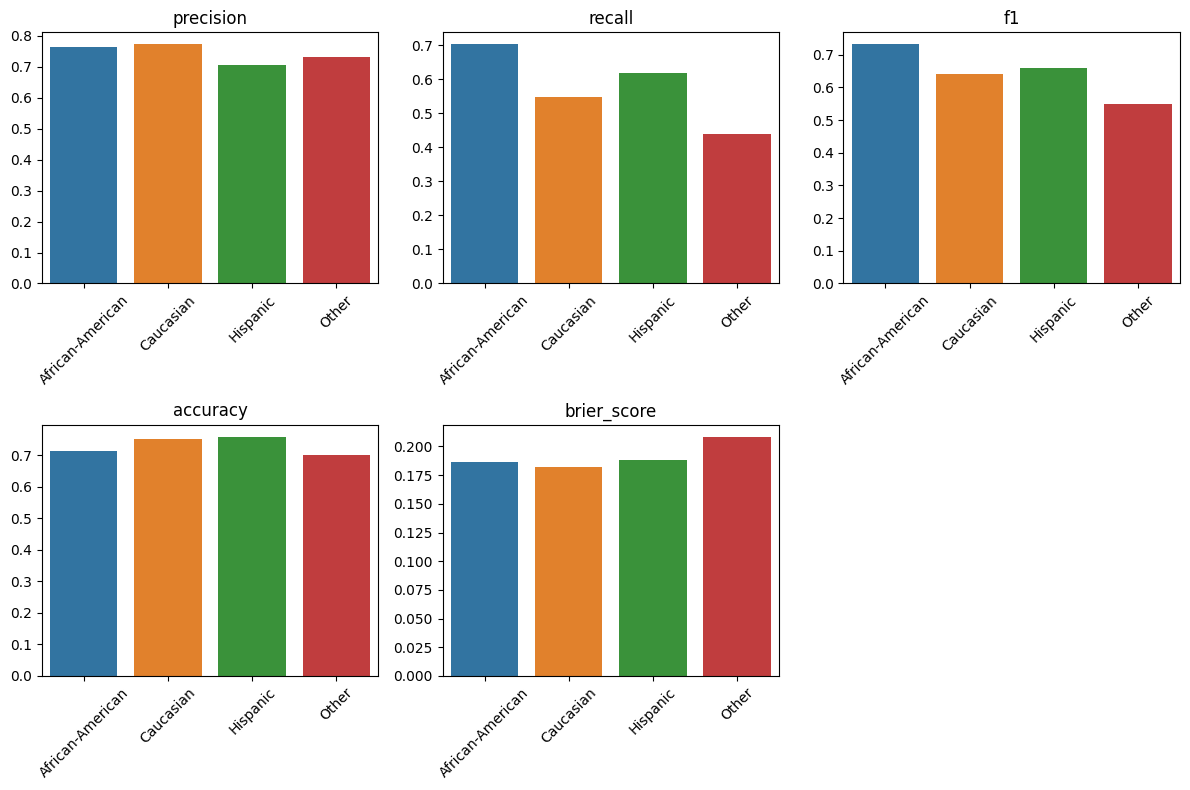

In [5]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
import seaborn as sns

# Calculando as probabilidades previstas
y_pred_proba = ensemble_clf.predict_proba(X_test_transformed)[:, 1]

# Calculando as curvas de calibração
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

# Plotando a curva de calibração
plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Calibrated model')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Predicted probability')
plt.ylabel('True probability')
plt.title('Calibration curve')
plt.legend()
plt.show()

# Função para calcular os erros
def calculate_errors(y_true, y_pred, y_pred_proba):
    errors = {}
    errors['precision'], errors['recall'], errors['f1'], errors['accuracy'] = get_metrics(y_true, y_pred)
    errors['brier_score'] = np.mean((y_true - y_pred_proba) ** 2)
    return errors

# Função para calcular as métricas específicas para a classe de recidivismo (1)
def get_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, pos_label=1)
    recall = recall_score(y_true, y_pred, pos_label=1)
    f1 = f1_score(y_true, y_pred, pos_label=1)
    accuracy = accuracy_score(y_true, y_pred)
    return precision, recall, f1, accuracy

# Calculando os erros gerais
overall_errors = calculate_errors(y_test, y_pred, y_pred_proba)
print("Overall Errors:")
print(overall_errors)

# Mapeando os índices reais para os índices relativos no conjunto de teste
index_mapping = {real_idx: i for i, real_idx in enumerate(X_test.index)}

# Calculando erros por raça agrupada
errors_by_race = {}
for race in X_test_cleaned['race_grouped'].unique():
    race_indices = X_test_cleaned[X_test_cleaned['race_grouped'] == race].index
    y_test_race = y_test.loc[race_indices]
    y_pred_race = y_pred_series.loc[race_indices]
    y_pred_proba_race = y_pred_proba[[index_mapping[idx] for idx in race_indices]]
    errors_by_race[race] = calculate_errors(y_test_race, y_pred_race, y_pred_proba_race)

print("\nErrors by Race:")
for race, errors in errors_by_race.items():
    print(f"Race: {race}")
    print(errors)

# Plotando os erros por raça
plt.figure(figsize=(12, 8))
metrics = ['precision', 'recall', 'f1', 'accuracy', 'brier_score']
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    sns.barplot(x=list(errors_by_race.keys()), y=[errors[metric] for errors in errors_by_race.values()])
    plt.title(metric)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


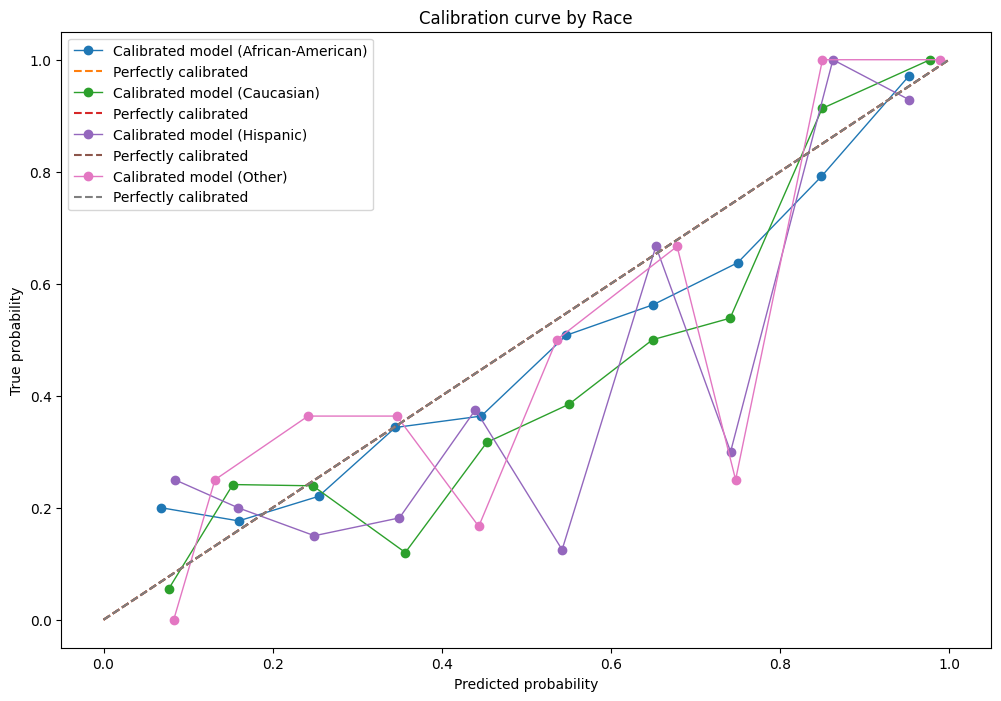

Brier score for African-American: 0.1864
Brier score for Caucasian: 0.1820
Brier score for Hispanic: 0.1880
Brier score for Other: 0.2084


In [6]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt

# Função para plotar a curva de calibração
def plot_calibration_curve(y_true, y_prob, title):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label=title)
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')

# Adicionar novamente a coluna 'race_grouped' nos dados de teste
X_test_cleaned = clean_data(X_test)

# Converter y_pred_proba para DataFrame para usar loc
y_pred_proba_df = pd.DataFrame(y_pred_proba, index=X_test.index, columns=['y_pred_proba'])

# Plotando curvas de calibração por raça
races = X_test_cleaned['race_grouped'].unique()

plt.figure(figsize=(12, 8))

brier_scores = {}

for race in races:
    race_indices = X_test_cleaned[X_test_cleaned['race_grouped'] == race].index
    y_test_race = y_test.loc[race_indices]
    
    # Selecionar y_pred_proba alinhado com os índices de y_test_race
    y_pred_proba_race = y_pred_proba_df.loc[race_indices, 'y_pred_proba']

    # Calcular Brier score
    brier_score = brier_score_loss(y_test_race, y_pred_proba_race)
    brier_scores[race] = brier_score

    plot_calibration_curve(y_test_race, y_pred_proba_race, f'Calibrated model ({race})')

plt.xlabel('Predicted probability')
plt.ylabel('True probability')
plt.title('Calibration curve by Race')
plt.legend()
plt.show()

# Exibir Brier scores
for race, score in brier_scores.items():
    print(f"Brier score for {race}: {score:.4f}")


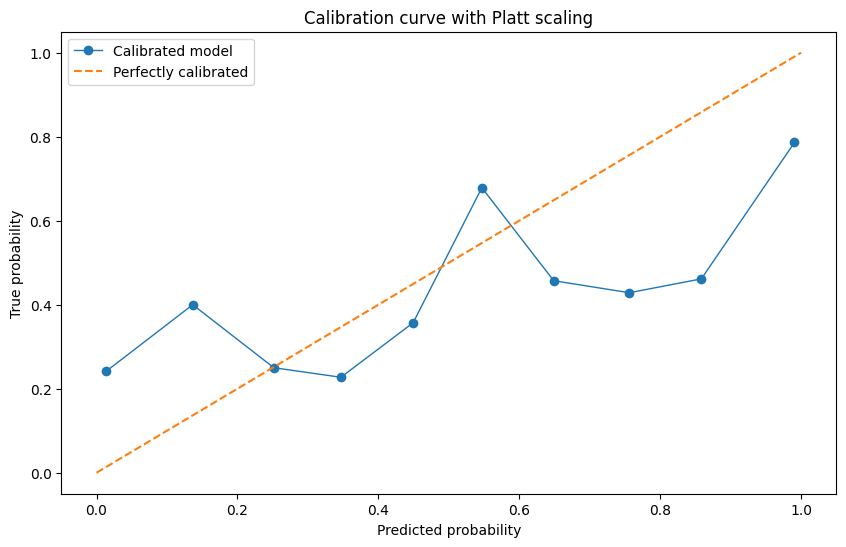

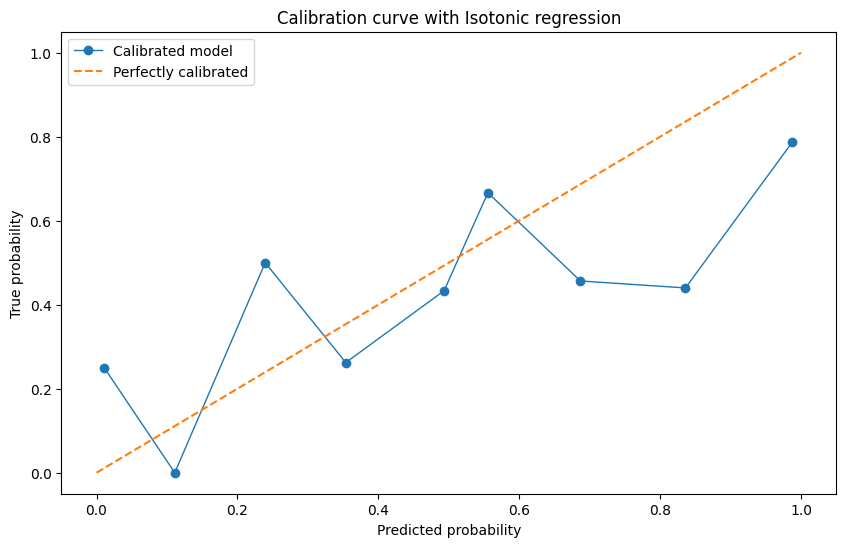


Metrics with Platt scaling:
Precision: 0.73
Recall: 0.68
F1-Score: 0.70
Accuracy: 0.73
Brier Score: 0.23

Metrics with Isotonic regression:
Precision: 0.73
Recall: 0.69
F1-Score: 0.71
Accuracy: 0.73
Brier Score: 0.24


In [7]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import matplotlib.pyplot as plt

# Calibrando o ensemble classifier com Platt scaling
calibrated_clf_platt = CalibratedClassifierCV(ensemble_clf, method='sigmoid', cv='prefit')
calibrated_clf_platt.fit(X_train_transformed, y_train)

# Calibrando o ensemble classifier com Isotonic regression
calibrated_clf_isotonic = CalibratedClassifierCV(ensemble_clf, method='isotonic', cv='prefit')
calibrated_clf_isotonic.fit(X_train_transformed, y_train)

# Função para calcular e plotar a curva de calibração
def plot_calibration_curve(y_test, y_pred_proba, title):
    prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

    plt.figure(figsize=(10, 6))
    plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Calibrated model')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
    plt.xlabel('Predicted probability')
    plt.ylabel('True probability')
    plt.title(title)
    plt.legend()
    plt.show()

# Avaliando o modelo calibrado com Platt scaling
y_pred_proba_platt = calibrated_clf_platt.predict_proba(X_test_transformed)[:, 1]
plot_calibration_curve(y_test, y_pred_proba_platt, 'Calibration curve with Platt scaling')

# Avaliando o modelo calibrado com Isotonic regression
y_pred_proba_isotonic = calibrated_clf_isotonic.predict_proba(X_test_transformed)[:, 1]
plot_calibration_curve(y_test, y_pred_proba_isotonic, 'Calibration curve with Isotonic regression')

# Função para calcular e imprimir as métricas
def print_metrics(y_test, y_pred, y_pred_proba):
    overall_precision, overall_recall, overall_f1, overall_accuracy = get_metrics(y_test, y_pred)
    brier_score = np.mean((y_test - y_pred_proba) ** 2)
    print(f"Precision: {overall_precision:.2f}")
    print(f"Recall: {overall_recall:.2f}")
    print(f"F1-Score: {overall_f1:.2f}")
    print(f"Accuracy: {overall_accuracy:.2f}")
    print(f"Brier Score: {brier_score:.2f}")

# Avaliando as métricas do modelo calibrado com Platt scaling
y_pred_platt = (y_pred_proba_platt >= threshold).astype(int)
print("\nMetrics with Platt scaling:")
print_metrics(y_test, y_pred_platt, y_pred_proba_platt)

# Avaliando as métricas do modelo calibrado com Isotonic regression
y_pred_isotonic = (y_pred_proba_isotonic >= threshold).astype(int)
print("\nMetrics with Isotonic regression:")
print_metrics(y_test, y_pred_isotonic, y_pred_proba_isotonic)


In [8]:
from sklearn.metrics import brier_score_loss

# Calculando a Brier score para o modelo não calibrado
brier_score_original = brier_score_loss(y_test, y_pred_proba)

# Calculando a Brier score para o modelo calibrado com Platt Scaling
brier_score_platt = brier_score_loss(y_test, y_pred_proba_platt)

# Calculando a Brier score para o modelo calibrado com Isotonic Regression
brier_score_isotonic = brier_score_loss(y_test, y_pred_proba_isotonic)

print(f"Brier score (Original): {brier_score_original:.4f}")
print(f"Brier score (Platt Scaling): {brier_score_platt:.4f}")
print(f"Brier score (Isotonic Regression): {brier_score_isotonic:.4f}")

Brier score (Original): 0.1861
Brier score (Platt Scaling): 0.2340
Brier score (Isotonic Regression): 0.2352


In [9]:
from sklearn.model_selection import StratifiedKFold

# Definir o número de folds
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits)

# Dados de entrada
X = df.drop(columns=['is_recid'])
y = df['is_recid']

# Inicializando listas para armazenar as métricas
precision_scores = []
recall_scores = []
f1_scores = []
accuracy_scores = []

# Realizando a validação cruzada estratificada
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Ajustando o pipeline nos dados de treino
    pipeline.fit(X_train)
    
    # Transformando os dados de treino e teste
    X_train_transformed = pipeline.transform(X_train)
    X_test_transformed = pipeline.transform(X_test)
    
    # Ajustando o classificador com os dados transformados de treino
    ensemble_clf.fit(X_train_transformed, y_train)
    
    # Calculando as métricas com o threshold de 0.6
    y_pred_proba = ensemble_clf.predict_proba(X_test_transformed)[:, 1]
    threshold = 0.6
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Calculando as métricas
    precision, recall, f1, accuracy = get_metrics(y_test, y_pred)
    
    # Armazenando as métricas
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    accuracy_scores.append(accuracy)

# Calculando as médias das métricas
print(f"Average Precision: {np.mean(precision_scores):.2f}")
print(f"Average Recall: {np.mean(recall_scores):.2f}")
print(f"Average F1-Score: {np.mean(f1_scores):.2f}")
print(f"Average Accuracy: {np.mean(accuracy_scores):.2f}")

Average Precision: 0.76
Average Recall: 0.64
Average F1-Score: 0.70
Average Accuracy: 0.73


In [10]:
from sklearn.model_selection import StratifiedKFold

# Definir o número de folds
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits)

# Dados de entrada
X = df.drop(columns=['is_recid'])
y = df['is_recid']

# Inicializando listas para armazenar as métricas
precision_scores = []
recall_scores = []
f1_scores = []
accuracy_scores = []

# Realizando a validação cruzada estratificada
for train_index, test_index in skf.split(X, df['race']):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Ajustando o pipeline nos dados de treino
    pipeline.fit(X_train)
    
    # Transformando os dados de treino e teste
    X_train_transformed = pipeline.transform(X_train)
    X_test_transformed = pipeline.transform(X_test)
    
    # Ajustando o classificador com os dados transformados de treino
    ensemble_clf.fit(X_train_transformed, y_train)
    
    # Calculando as métricas com o threshold de 0.6
    y_pred_proba = ensemble_clf.predict_proba(X_test_transformed)[:, 1]
    threshold = 0.6
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Calculando as métricas
    precision, recall, f1, accuracy = get_metrics(y_test, y_pred)
    
    # Armazenando as métricas
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    accuracy_scores.append(accuracy)

# Calculando as médias das métricas
print(f"Average Precision: {np.mean(precision_scores):.2f}")
print(f"Average Recall: {np.mean(recall_scores):.2f}")
print(f"Average F1-Score: {np.mean(f1_scores):.2f}")
print(f"Average Accuracy: {np.mean(accuracy_scores):.2f}")

Average Precision: 0.76
Average Recall: 0.64
Average F1-Score: 0.70
Average Accuracy: 0.73


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
import numpy as np
import re

# Funções de limpeza e transformação
def clean_c_charge_degree(degree):
    return re.sub(r'[^a-zA-Z]', '', degree)

def extract_year(date):
    return pd.to_datetime(date).year

def extract_month(date):
    return pd.to_datetime(date).month

def process_dates(df):
    df['dob_year'] = df['dob'].apply(extract_year)
    df['c_jail_year'] = df['c_jail_in'].apply(extract_year)
    df['c_jail_month'] = df['c_jail_in'].apply(extract_month)
    return df.drop(columns=['dob', 'c_jail_in'])

def agrupar_tipo_crime(descricao):
    if pd.isna(descricao):
        return 'other'
    descricao = descricao.lower()
    if 'battery' in descricao or 'assault' in descricao or 'violence' in descricao or 'murder' in descricao or 'batt' in descricao:
        return 'violence'
    elif 'theft' in descricao or 'burglary' in descricao or 'robbery' in descricao:
        return 'robbery'
    elif 'drug' in descricao or 'possession' in descricao or 'trafficking' in descricao or 'poss' in descricao or 'cocaine' in descricao or 'heroin' in descricao or 'deliver' in descricao or 'traffick' in descricao:
        return 'drugs'
    elif 'driving' in descricao or 'traffic' in descricao or 'license' in descricao or 'driv' in descricao or 'vehicle' in descricao or 'conduct' in descricao:
        return 'traffic'
    else:
        return 'other'

def group_races(df):
    race_map = df['race'].value_counts()
    common_races = race_map[race_map >= 50].index.tolist()
    df['race_grouped'] = df['race'].apply(lambda x: x if x in common_races else 'Other')
    return df.drop(columns=['race'])

def clean_data(df):
    # Drop columns
    df = df.drop(columns=['id', 'name', 'c_case_number', 'c_offense_date', 'c_arrest_date'])
    
    # Apply custom transformations
    df['c_charge_degree'] = df['c_charge_degree'].apply(clean_c_charge_degree)
    df['c_charge_desc'] = df['c_charge_desc'].apply(agrupar_tipo_crime)
    # Group races
    df = group_races(df)
    
    # Convert to categorical
    df['c_charge_desc'] = pd.Categorical(df['c_charge_desc'], categories=['violence', 'robbery', 'drugs', 'traffic', 'other'])
    df['sex'] = df['sex'].astype('category')
    df['race_grouped'] = df['race_grouped'].astype('category')
    df['c_charge_degree'] = df['c_charge_degree'].astype('category')
    
    # Process dates
    df = process_dates(df)
    
    return df

# Função para calcular métricas específicas para a classe de recidivismo (1)
def get_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, pos_label=1)
    recall = recall_score(y_true, y_pred, pos_label=1)
    f1 = f1_score(y_true, y_pred, pos_label=1)
    accuracy = accuracy_score(y_true, y_pred)
    return precision, recall, f1, accuracy

# Dados de entrada
numerical_cols = ['juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'dob_year', 'c_jail_year', 'c_jail_month']
categorical_cols = ['sex', 'race_grouped', 'c_charge_degree', 'c_charge_desc']

# Criando preprocessador
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, interaction_only=False, include_bias=False))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Definindo os classificadores individuais
xgb_clf = XGBClassifier(
    colsample_bytree=0.9086987696743714,
    learning_rate=0.191928717897877,
    max_depth=5,
    n_estimators=211,
    scale_pos_weight=5,
    subsample=0.9461200982120006,
    use_label_encoder=False,
    eval_metric='logloss'
)

rf_clf = RandomForestClassifier(n_estimators=200, random_state=42)

lr_clf = LogisticRegression(max_iter=200, random_state=42)

# Definindo o ensemble (voting classifier)
ensemble_clf = VotingClassifier(
    estimators=[('xgb', xgb_clf), ('rf', rf_clf), ('lr', lr_clf)],
    voting='soft'
)

# Limpeza dos dados
df = clean_data(df)

# Dados de entrada
numerical_cols = ['juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'dob_year', 'c_jail_year', 'c_jail_month']
categorical_cols = ['sex', 'race_grouped', 'c_charge_degree', 'c_charge_desc']

# Criando preprocessador
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, interaction_only=False, include_bias=False))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Definindo os classificadores individuais
xgb_clf = XGBClassifier(
    colsample_bytree=0.9086987696743714,
    learning_rate=0.191928717897877,
    max_depth=5,
    n_estimators=211,
    scale_pos_weight=5,
    subsample=0.9461200982120006,
    use_label_encoder=False,
    eval_metric='logloss'
)

rf_clf = RandomForestClassifier(n_estimators=200, random_state=42)

lr_clf = LogisticRegression(max_iter=200, random_state=42)

# Definindo o ensemble (voting classifier)
ensemble_clf = VotingClassifier(
    estimators=[('xgb', xgb_clf), ('rf', rf_clf), ('lr', lr_clf)],
    voting='soft'
)

# Definindo o pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', ensemble_clf)
])


# Dividindo os dados em treino e teste
X = df.drop(columns=['is_recid'])
y = df['is_recid']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Ajustando o pipeline nos dados de treino
pipeline.fit_transform(X_train, y_train)

# Calculando as métricas com o threshold de 0.6
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
threshold = 0.6
y_pred = (y_pred_proba >= threshold).astype(int)

overall_precision, overall_recall, overall_f1, overall_accuracy = get_metrics(y_test, y_pred)
print(f"Threshold: {threshold}")
print(f"Overall Precision: {overall_precision:.2f}, Recall: {overall_recall:.2f}, F1-Score: {overall_f1:.2f}, Accuracy: {overall_accuracy:.2f}")

Threshold: 0.6
Overall Precision: 0.76, Recall: 0.64, F1-Score: 0.70, Accuracy: 0.73


In [12]:
# Salvando o pipeline e o ensemble classifier
import joblib
joblib.dump(pipeline, 'pipeline.pkl')

# Salvando as colunas e tipos de dados esperados
import json
with open('columns.json', 'w') as fh:
    json.dump(X_train.columns.tolist(), fh)

import pickle
with open('dtypes.pkl', 'wb') as fh:
    pickle.dump(X_train.dtypes, fh)

In [13]:
X_train.columns.tolist()

['sex',
 'age',
 'c_charge_degree',
 'c_charge_desc',
 'juv_fel_count',
 'juv_misd_count',
 'juv_other_count',
 'priors_count',
 'race_grouped',
 'dob_year',
 'c_jail_year',
 'c_jail_month']

In [14]:
pipeline.steps

[('preprocessor',
  ColumnTransformer(transformers=[('num',
                                   Pipeline(steps=[('imputer', SimpleImputer()),
                                                   ('scaler', StandardScaler()),
                                                   ('poly',
                                                    PolynomialFeatures(include_bias=False))]),
                                   ['juv_fel_count', 'juv_misd_count',
                                    'juv_other_count', 'priors_count', 'dob_year',
                                    'c_jail_year', 'c_jail_month']),
                                  ('cat',
                                   Pipeline(steps=[('imputer',
                                                    SimpleImputer(strategy='most_frequent')),
                                                   ('onehot',
                                                    OneHotEncoder(drop='first',
                                                           